In [9]:
import scipy.io
import numpy as np
import pandas as pd

mat_data = scipy.io.loadmat('wiki_test.mat')

wiki_data = mat_data['wiki'][0, 0]

data_dict = {
    'dob': wiki_data['dob'][0],
    'photo_taken': wiki_data['photo_taken'][0],
    'full_path': wiki_data['full_path'][0],
    'gender': wiki_data['gender'][0],
    'name': wiki_data['name'][0],
    'face_location': wiki_data['face_location'][0],
    'face_score': wiki_data['face_score'][0],
    'second_face_score': wiki_data['second_face_score'][0],
    'age': wiki_data['age'][0]
}

df = pd.DataFrame(data_dict)

df = df[['age', 'gender', 'full_path']]
df['full_path'] = df['full_path'].str[0]
df['full_path'] = 'wiki_crop/' + df['full_path']

df = df.dropna()

print(df)

       age  gender                                  full_path
0       28     1.0  wiki_crop/17/10000217_1981-05-05_2009.jpg
1       39     1.0  wiki_crop/48/10000548_1925-04-04_1964.jpg
2       59     1.0    wiki_crop/12/100012_1948-07-03_2008.jpg
3       31     1.0  wiki_crop/65/10001965_1930-05-23_1961.jpg
4       41     0.0  wiki_crop/16/10002116_1971-05-31_2012.jpg
...    ...     ...                                        ...
62323   26     1.0   wiki_crop/49/9996949_1937-04-17_1963.jpg
62324   22     1.0   wiki_crop/32/9997032_1947-07-30_1970.jpg
62325   40     1.0   wiki_crop/09/9998109_1972-12-27_2013.jpg
62326   29     1.0   wiki_crop/00/9999400_1981-12-13_2011.jpg
62327   54     0.0    wiki_crop/80/999980_1954-06-11_2008.jpg

[59685 rows x 3 columns]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from skimage.io import imread
from skimage.transform import resize
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
import os

# # Grayscale
# def process_image(path, target_size=(64, 64)):
#     try:
#         img = imread(path)
#         img = resize(img, target_size, anti_aliasing=True)
#         if len(img.shape) > 2:
#             img = img.mean(axis=2)
#         return img.flatten()
#     except:
#         return None

# Pixel by Pixel (with colors)
def process_image(path, target_size=(64, 64)):
    try:
        img = imread(path)               # Load image
        img = resize(img, target_size)   # Resize to 64x64
        if len(img.shape) == 2:          # If grayscale, convert to RGB
            print('gray')
            img = np.stack([img]*3, axis=-1)
        return img.flatten()             # Flatten to 1D array (64x64x3=12288 dim)
    except:
        return None

print("Extracting features in parallel...")
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(process_image)(path) for path in df['full_path']
)

# Remove unsuccessful successful extractions
valid_features = []
valid_indices = []
for i, feat in enumerate(results):
    if feat is not None:
        valid_features.append(feat)
        valid_indices.append(i)

valid_df = df.iloc[valid_indices].copy()
x = np.array(valid_features)
y_age = valid_df['age'].values
y_gender = valid_df['gender'].values

# Train-test split - 80% Training
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    x, y_age, y_gender, test_size=0.2, random_state=42
)

Extracting features in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17792611464614472s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07479691505432129s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1169893741607666s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.1s
[Parallel(n_jobs

In [ ]:
# PCA
print("\nApplying PCA dimensionality reduction...")
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Reduced from {X_train.shape[1]} to {X_train_pca.shape[1]} features")

In [ ]:
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import r2_score

# Age model
print("\nTraining age model...")
age_model = LinearRegression()
age_model.fit(X_train_pca, y_age_train)
age_pred = age_model.predict(X_test_pca)
print(f"Age MAE: {mean_absolute_error(y_age_test, age_pred):.2f} years")
print(f"Age RMSE: {mean_squared_error(y_age_test, age_pred)**0.5:.2f} years")
print(f"Age R²: {r2_score(y_age_test, age_pred):.2f}")

# KNN for Age
age_knn = KNeighborsRegressor(n_neighbors=8)
age_knn.fit(X_train_pca, y_age_train)
age_knn_pred = age_knn.predict(X_test_pca)
print(f"KNN Age MAE: {mean_absolute_error(y_age_test, age_knn_pred):.2f} years")
print(f"KNN Age RMSE: {mean_squared_error(y_age_test, age_knn_pred)**0.5:.2f} years")
print(f"Age R²: {r2_score(y_age_test, age_knn_pred):.2f}")

# # MLP for Age
# age_mlp = MLPRegressor(hidden_layer_sizes=(64, 32), 
#                       activation='relu', 
#                       solver='adam', 
#                       max_iter=100, 
#                       random_state=42)
# age_mlp.fit(X_train_pca, y_age_train)
# age_mlp_pred = age_mlp.predict(X_test_pca)
# print(f"MLP Age MAE: {mean_absolute_error(y_age_test, age_mlp_pred):.2f} years")
# print(f"MLP Age RMSE: {mean_squared_error(y_age_test, age_mlp_pred)**0.5:.2f} years")
# print(f"Age R²: {r2_score(y_age_test, age_mlp_pred):.2f}")
age_mlp = MLPRegressor(hidden_layer_sizes=(100,), 
                        activation='relu', 
                        solver='adam', 
                        max_iter=100, # 100 usually
                        alpha=0.01,
                        batch_size=64,
                        early_stopping=True,
                        random_state=42)
age_mlp.fit(X_train_pca, y_age_train)
age_mlp_pred = age_mlp.predict(X_test_pca)
print(f"MLP Age MAE: {mean_absolute_error(y_age_test, age_mlp_pred):.2f} years")
print(f"MLP Age RMSE: {mean_squared_error(y_age_test, age_mlp_pred)**0.5:.2f} years")
print(f"Age R²: {r2_score(y_age_test, age_mlp_pred):.2f}")

# Gender model
print("\nTraining gender model...")
gender_model = LogisticRegression(max_iter=100, solver = "lbfgs")
gender_model.fit(X_train_pca, y_gender_train)
gender_pred = gender_model.predict(X_test_pca)
print(f"Gender accuracy: {accuracy_score(y_gender_test, gender_pred):.2f}")

# KNN for Gender
gender_knn = KNeighborsClassifier(n_neighbors=8)
gender_knn.fit(X_train_pca, y_gender_train)
gender_knn_pred = gender_knn.predict(X_test_pca)
print(f"KNN Gender accuracy: {accuracy_score(y_gender_test, gender_knn_pred):.2f}")

# # MLP for Gender
# gender_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), 
#                           activation='relu', 
#                           solver='adam', 
#                           max_iter=100, 
#                           random_state=42)
# gender_mlp.fit(X_train_pca, y_gender_train)
# gender_mlp_pred = gender_mlp.predict(X_test_pca)
# print(f"MLP Gender accuracy: {accuracy_score(y_gender_test, gender_mlp_pred):.2f}")
gender_mlp = MLPClassifier(hidden_layer_sizes=(100,), 
                        activation='relu', 
                        solver='adam', 
                        max_iter=100, 
                        alpha=0.01,
                        batch_size=64,
                        early_stopping=True,
                        random_state=42)
gender_mlp.fit(X_train_pca, y_gender_train)
gender_mlp_pred = gender_mlp.predict(X_test_pca)
print(f"MLP Gender accuracy: {accuracy_score(y_gender_test, gender_mlp_pred):.2f}")


Training age model...
Age MAE: 17.17 years
Age RMSE: 27.06 years
Age R²: -0.22
KNN Age MAE: 15.17 years
KNN Age RMSE: 25.09 years
Age R²: -0.05
MLP Age MAE: 13.43 years
MLP Age RMSE: 23.37 years
Age R²: 0.09

Training gender model...


c:\Users\danie\OneDrive\Desktop\last\334\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Gender accuracy: 0.83
KNN Gender accuracy: 0.80
MLP Gender accuracy: 0.84


In [ ]:
import time
import json

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, average_precision_score, f1_score

def eval_searchcv(clfName, clf, clfGrid,
                  xTrain, yTrain, xTest, yTest,
                  perfDict, rocDF, bestParamDict):
    # evaluate grid search and add to perfDict
    cls_perf, cls_roc, gs_p  = eval_gridsearch(clf, clfGrid, xTrain,
                                               yTrain, xTest, yTest)
    perfDict[clfName + " (Grid)"] = cls_perf
    # add to ROC DF
    rocRes = pd.DataFrame(cls_roc)
    rocRes["model"] = clfName
    rocDF = pd.concat([rocDF, rocRes], ignore_index=True)
    # evaluate random search and add to perfDict
    bestParamDict[clfName] = {"Grid": gs_p}
    return perfDict, rocDF, bestParamDict

def eval_gridsearch(clf, pgrid, xTrain, yTrain, xTest, yTest):

    start = time.time()
    
    grid = GridSearchCV(estimator=clf, param_grid=pgrid, cv=5, scoring='roc_auc')
    grid.fit(xTrain, yTrain)
    
    best_clf = grid.best_estimator_
    best_clf.fit(xTrain, yTrain)
    
    yProb = best_clf.predict_proba(xTest)[:, 1]
    yPred = best_clf.predict(xTest)
    
    fpr, tpr, _ = roc_curve(yTest, yProb)
    roc_auc = auc(fpr, tpr)
    auprc = average_precision_score(yTest, yProb)
    f1 = f1_score(yTest, yPred)
    
    timeElapsed = time.time() - start
    
    resultDict = {
        "AUC": roc_auc,
        "AUPRC": auprc,
        "F1": f1,
        "Time": timeElapsed
    }
    
    roc = {
        "fpr": fpr,
        "tpr": tpr
    }
    
    bestParams = grid.best_params_
    
    return resultDict, roc, bestParams

def get_parameter_grid(mName):

    if mName == "LR (None)":
        pGrid = {
            'penalty': [None], 
            'solver': ['lbfgs'],
            'max_iter': [100]
        }
    elif mName == "KNN":
        pGrid = {
            'n_neighbors': [8],
            'metric': ['euclidean']
        }
    elif mName == "NN":
        pGrid = {
            # 'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
            'hidden_layer_sizes': [(100,)],
            'activation': ['relu'],
            # 'alpha': [0.0001, 0.001, 0.01, 0.1],  # L2 regularization
            # 'alpha': [0.001, 0.01],  # L2 regularization
            'alpha': [0.01],  # L2 regularization
            # 'learning_rate': ['constant', 'adaptive'],
            # 'learning_rate_init': [0.001, 0.01],
            'batch_size': [64],
            'max_iter': [100],
            'early_stopping': [True],
            'solver': ['adam']
        }
    
    return pGrid


perfDict = {}
rocDF = pd.DataFrame()
bestParamDict = {}

unregLrName = "LR (None)"
unregLrGrid = get_parameter_grid(unregLrName)
perfDict, rocDF, bestParamDict = eval_searchcv(unregLrName, gender_model, unregLrGrid,
                                                X_train_pca, y_gender_train, X_test_pca, y_gender_test,
                                                perfDict, rocDF, bestParamDict)

nnName = "NN"
nnGrid = get_parameter_grid(nnName)
perfDict, rocDF, bestParamDict = eval_searchcv(nnName, gender_mlp, nnGrid,
                                                X_train_pca, y_gender_train, X_test_pca, y_gender_test,
                                                perfDict, rocDF, bestParamDict)

knnGenderName = "KNN"
knnGenderGrid = get_parameter_grid(knnGenderName)
perfDict, rocDF, bestParamDict = eval_searchcv(knnGenderName, gender_knn, knnGenderGrid,
                                                X_train_pca, y_gender_train, X_test_pca, y_gender_test,
                                                perfDict, rocDF, bestParamDict)



perfDF = pd.DataFrame.from_dict(perfDict, orient='index')
print(perfDF)
rocDF.to_csv('rocOutput_reg.csv', index=False)
with open('bestParams_reg.json', 'w') as f:
    json.dump(bestParamDict, f)


c:\Users\danie\OneDrive\Desktop\last\334\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\danie\OneDrive\Desktop\last\334\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

C:\Users\danie\AppData\Local\Temp\ipykernel_12576\511255104.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(model_data['tpr'], model_data['fpr'])


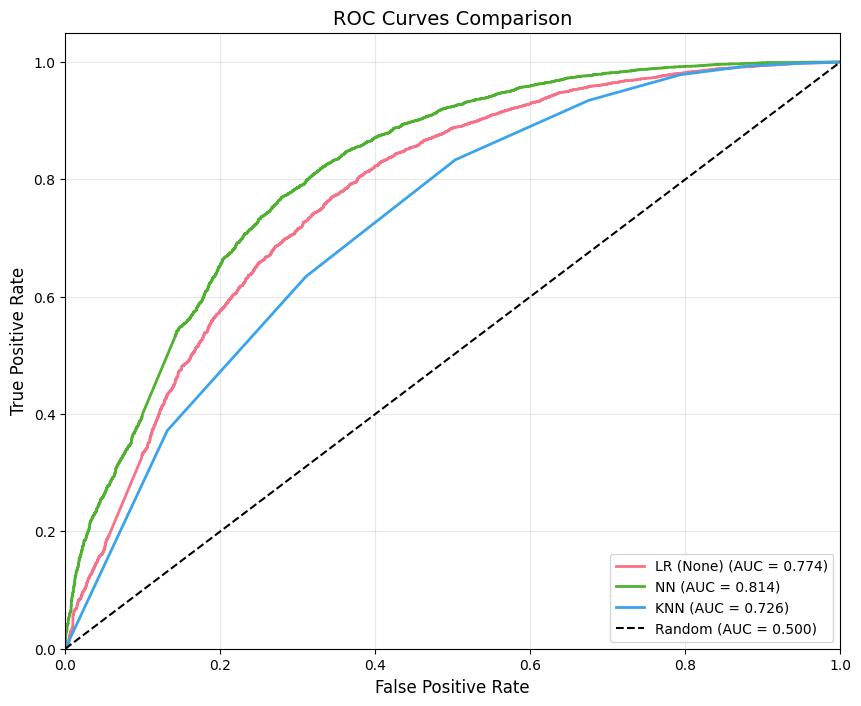

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the ROC data
roc_data = pd.read_csv('rocOutput_reg.csv')

# Calculate AUC for each model
auc_values = {}
for model in roc_data['model'].unique():
    model_data = roc_data[roc_data['model'] == model]
    auc = np.trapz(model_data['tpr'], model_data['fpr'])
    auc_values[model] = auc

# Create the plot
plt.figure(figsize=(10, 8))

# Set a color palette
palette = sns.color_palette("husl", len(roc_data['model'].unique()))

# Plot ROC curve for each model
for i, model in enumerate(roc_data['model'].unique()):
    model_data = roc_data[roc_data['model'] == model]
    plt.plot(model_data['fpr'], model_data['tpr'], 
             color=palette[i],
             linewidth=2,
             label=f'{model} (AUC = {auc_values[model]:.3f})')

# Add labels and title
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14)

# Add diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')

# Add legend
plt.legend(fontsize=10, loc='lower right')

# Set limits and grid
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, alpha=0.3)

# Save the plot
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()